<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/analysis/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:str='20180501', end:str=str(datetime.datetime.now().date().strftime("%Y%m%d")), interval='day'):
    url = 'https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + '&requestType=1&startTime=' + start + '&endTime=' + end +  '&timeframe=' + interval
    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], float), 'High':np.array(data[:,2], float), 'Low':np.array(data[:,3], float),\
       'Close':np.array(data[:,4], float), 'Volume':np.array(data[:,5], float)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df

In [2]:
stock = Stock('KOSPI')
df = stock.get_price('20170101', 'day')
df['Change'] = df['Close']/df['Open']
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-01-02,2022.23,2031.79,2015.68,2026.16,229874.0,1.001943
2017-01-03,2034.31,2044.07,2028.47,2043.97,268127.0,1.004749
2017-01-04,2046.29,2046.29,2040.61,2045.64,371488.0,0.999682
2017-01-05,2045.52,2046.50,2039.49,2041.95,541343.0,0.998255
2017-01-06,2048.11,2051.84,2045.66,2049.12,455350.0,1.000493
...,...,...,...,...,...,...
2021-10-06,2986.06,2993.47,2908.30,2908.31,901721.0,0.973962
2021-10-07,2936.87,2961.53,2927.60,2959.46,595381.0,1.007692
2021-10-08,2977.82,2978.08,2949.01,2956.30,668946.0,0.992773


In [3]:
# 전날 조건
pre_lower = 0
pre_upper = 1
range = df[df['Change'].between(pre_lower, pre_upper)]

# show after range
range_next = df[df.shift(1)['Change'].between(pre_lower, pre_upper)]

# 전날 조건 비례 오늘
lower = 1
upper = 2
sum(range_next['Change'].between(lower, upper)/ len(range_next['Change']))

0.5108514190317178

In [4]:
from dateutil import relativedelta

def get_next(date):
  date = datetime.datetime.strptime(date, '%Y%m%d')
  nextmonth = date + relativedelta.relativedelta(months=1)
  return str(nextmonth.strftime("%Y%m%d"))

In [5]:
dic = {}
start = '20000101'
end = get_next(start)

while end != '20211001':
  end = get_next(start)
  stock = Stock('KOSPI')
  dic[start] = stock.get_price(start, end)
  print('.', end='')
  start = end

.....................................................................................................................................................................................................................................................................

In [6]:
# get volatility per month

for d in dic:
  dic[d]['Log returns'] = np.log(dic[d]['Close']/dic[d]['Close'].shift())
  volatility = dic[d]['Log returns'].std()*252**.5
  dic[d]['volatility'] = volatility

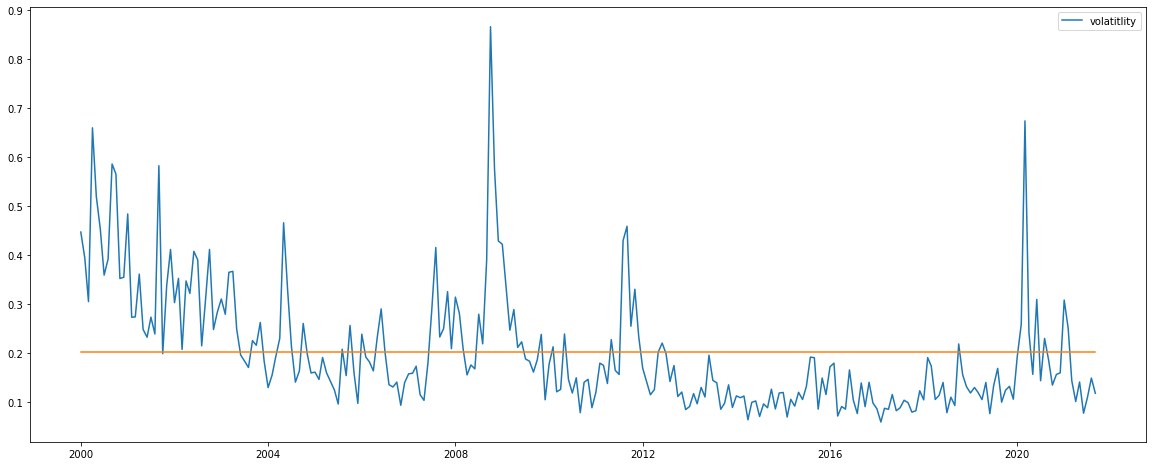

In [7]:
import matplotlib.pyplot as plt

y = [dic[x]['volatility'][0] for x in dic]
x = [datetime.datetime.strptime(x, '%Y%m%d') for x in list(dic)]
plt.figure(figsize=(20,8))
plt.plot(x, y)

# average
plt.plot(x, [sum([dic[x]['volatility'][0] for x in dic])/ len([dic[x]['volatility'][0] for x in dic])] * len(x))
plt.legend(['volatitlity'])
plt.show()